In [2]:
# Data
import yfinance as yf
import yahooquery

# Maths
import numpy as np
import pandas as pd
from scipy.optimize import minimize, differential_evolution
from scipy import stats
from statsmodels.tsa.stattools import coint

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns

# Data handling
import pandas_datareader as pdr
import pandas_market_calendars as mcal

# Utility
import datetime

In [4]:
def Get_top_10_ETF_symbols(ETF):
    holdings = yahooquery.Ticker(ETF).fund_holding_info[ETF]['holdings']
    return [holding['symbol'] for holding in holdings]
def Get_ETF_data(ETF):
    tickers = Get_top_10_ETF_symbols(ETF)
    df = yf.download(tickers, start=valid_start_day)['Close']
    df = df.dropna(axis=0, how='any')
    return df

In [12]:
# Date and Time
end_date = datetime.date.today()
start_date = end_date - datetime.timedelta(days=1200)
nyse = mcal.get_calendar('NYSE')
valid_dates = nyse.valid_days(start_date=start_date, end_date =end_date)
valid_start_day = valid_dates[0].date()
valid_end_day = valid_dates[-1].date()

# List of ETF: https://en.wikipedia.org/wiki/List_of_American_exchange-traded_funds 

#SMH_top_10_tickers = Get_top_10_ETF_symbols('SMH') # VanEck Semiconductor ETF    #####Seems work#####
#AMLP_top_10_tickers = Get_top_10_ETF_symbols('AMLP') # energy, ALPS Alerian MLP ETF   #####Seems work#####
#VDE_top_10_tickers = Get_top_10_ETF_symbols('VDE') # Vanguard Energy  
#XLF_top_10_tickers = Get_top_10_ETF_symbols('XLF') # Financial Select Sector SPDR
#VOO_top_10_tickers = Get_top_10_ETF_symbols('VOO') # Vanguard S&P 500 ETF

# Download data
df = Get_ETF_data('SMH')

[*********************100%%**********************]  10 of 10 completed


In [14]:
df.tail(5)

Ticker,ADI,AMAT,AMD,ASML,AVGO,LRCX,NVDA,QCOM,TSM,TXN
Date,,,,,,,,,,
2024-12-31,212.460007,162.630005,120.790001,693.080017,231.839996,72.230003,134.289993,153.619995,197.490005,187.509995
2025-01-02,211.350006,163.869995,120.629997,700.419983,231.979996,72.440002,138.309998,153.639999,201.580002,186.949997
2025-01-03,215.369995,170.059998,125.370003,714.359985,232.550003,75.110001,144.470001,157.830002,208.610001,190.509995
2025-01-06,218.000000,177.479996,129.550003,768.510010,236.410004,77.980003,149.429993,159.850006,220.009995,192.179993
2025-01-07,215.869995,177.820007,127.330002,757.580017,228.639999,77.519997,140.139999,160.520004,211.419998,192.210007


In [16]:
# Split data
def Log_return(df): # We use log return as the time series instead of the stock itself (got more nicer properties!)
    return np.log(df/df.shift(1)).dropna()
TT_split = 0.8 #you need constant update so Train-test split must be large to see good result

Train_df = df[:int(len(df)*TT_split)]
Train_df_return = Log_return(Train_df)

Test_df = df[int(len(df)*TT_split):]

In [18]:
def find_cointegrated_pairs(df):
    n = df.shape[1]
    score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    keys = df.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            S1 = df[keys[i]]
            S2 = df[keys[j]]
            result = coint(S1, S2) # return: Test Statistic, P-value, Critical Values
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            if pvalue < 0.01:
                pairs.append([keys[i], keys[j]])
    return score_matrix, pvalue_matrix, pairs

def calculate_spread_zscore(pair, df, window):
    stock1 = df[pair[0]]
    stock2 = df[pair[1]]
    spread = stock1 - stock2
    zscore = (spread - spread.rolling(window=window).mean()) / spread.rolling(window=window).std()
    return zscore

In [20]:
# Calculate rolling z
z_score_window = 20

# Find cointegrated pairs
score_matrix, pvalue_matrix, cointegrated_pairs = find_cointegrated_pairs(Train_df_return)

print(f"Found {len(cointegrated_pairs)} cointegrated pairs:")

Found 45 cointegrated pairs:


# Trading method
1) Trade at close
2) Long or Short a certine number of stocks every day based on mean reversion
3) z-entry and z-exit remain static
4) No cap on investment, just give the system however money it needs
5) Simple fixed feed: fix short fee (2%) and transaction cost
# Trading logic:
1) Get the z-entry and z-exit using past data
2) For each cointegrated pair, check:
   1) If not hold any position:
       1) If z-score > z-entry, Short the spread: Short S1 and Long S2
       2) If z-score < -1*z-entry, Long the spread: Long S1 Short S2
   2) If hold postion:
       1) If holding Short position and z-scores < z_exit, exit Short postion
       2) If holding Long position and z-score > -1*z-entry, exit Long positon 
3) Repeat this for a while and see what happen

In [440]:
def backtest(df,TT_split,pairs,z_score_window,z_entry,z_exit,opt_mode=False):
    Train_len = int(len(df)*(TT_split))
    if opt_mode:
        df_test = df.iloc[:Train_len]
        Portfolio_value = pd.DataFrame(index=df.index[:Train_len])
        Test_position = pd.DataFrame().reindex_like(df[:Train_len])
    else:
        df_test = df.iloc[Train_len:]
        Portfolio_value = pd.DataFrame(index=df.index[Train_len:])
        Test_position = pd.DataFrame().reindex_like(df[Train_len:])
    Test_position[:] = 0
    Transaction_cost = 4 #USD per transaction
    base_annual_fee_rate = 0.02  # 2% annually
    borrow_fee_daily = (base_annual_fee_rate) / 252

    for i, pair in enumerate(pairs):
        zscores = calculate_spread_zscore(pair,df,z_score_window)[Train_len:]
        assert len(zscores) == len(df)-Train_len #For debug
        position = 0
        share = 1 # how many stock do you want to short/long?
        
        for j in range(len(zscores)):
            j_adj = Train_len + j #trasnlate j into df loction
            #assert df.index[j_adj] == Test_position.index[j] #Make sure we are looking at the same day
            if position == 0:
                if zscores.iloc[j] > z_entry: # Short the spread: Short S1 Long S2
                    position = -1
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
                elif zscores.iloc[j] < -z_entry: # Long the spread: Long S1 Short S2
                    position = 1
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == -1:
                if zscores.iloc[j] < z_exit: # Exit short position: Buy back S1 and sell all S2
                    position = 0
                    Test_position[pair[0]].iloc[j] += share
                    Test_position[pair[1]].iloc[j] -= share
                    
            elif position == 1:
                if zscores.iloc[j] > -z_exit: # Exit long position: Sell all S1 and Buy back S2
                    position = 0
                    Test_position[pair[0]].iloc[j] -= share
                    Test_position[pair[1]].iloc[j] += share
    
    Test_position = Test_position.cumsum()
    keys = Test_position.keys()
        
    Portfolio_value[keys] = (Test_position[keys]*df_test[keys])
    Portfolio_value['risking'] = Portfolio_value.abs().sum(axis=1)
    Portfolio_value['stock worth'] = Portfolio_value[keys].sum(axis=1)
    Change_in_holding = Test_position-Test_position.shift(1)
    Portfolio_value['cash'] = 0.0 # initialize cash
    Portfolio_value.loc[Portfolio_value.index[0], 'cash'] = -Portfolio_value.loc[Portfolio_value.index[0], 'stock worth'] # need money to buy stock!!
    
    open_close_position_gain = (-Change_in_holding*df_test - Transaction_cost*Change_in_holding).sum(axis=1) # Calculate the profit from shorting + longing
    Portfolio_value['cash'] += open_close_position_gain # Profit from buy and sell - Transaction cost
    
    shorting_fee_cost = (Test_position[keys][Test_position[keys] < 0] * df_test[keys]).abs().sum(axis=1) * borrow_fee_daily
    Portfolio_value['cash'] -= shorting_fee_cost # Short selling fees
    
    Portfolio_value['cash'] = Portfolio_value['cash'].cumsum()
    Portfolio_value['Portfolio'] = Portfolio_value['cash'] + Portfolio_value['stock worth']

    if opt_mode:
        Portfolio_value['daily_return'] = Portfolio_value['Portfolio'].pct_change()
        mean_return = Portfolio_value['daily_return'].mean()
        var_return = Portfolio_value['daily_return'].var()
        downside_returns = Portfolio_value['daily_return'][Portfolio_value['daily_return'] < 0]
        downside_deviation = (downside_returns**2).mean()**0.5

        # Sortino Ratio with improved handling of zero downside deviation
        if downside_deviation > 0:
            sortino_ratio = mean_return/downside_deviation
        else:
            sortino_ratio = -1e6  # Large penalty for invalid configurations
        return sortino_ratio
        #return mean_return/var_return
    
    return Test_position, Portfolio_value

# Optimization:
1) Definition:
   1) Portfolio worth = cash + stocks worth(at close, could be negative based on long/short positions)
   2) Return = Portfolio_{t}/Portfolio_{t-1}
2) Optimize:
   2) Sharpe ratio = Return.mean()/Return.var()

I use differental evolution instead of simple gradiant decent since the opt surface might not be smooth enough in most cases

In [443]:
def optimize_zscore_params(df, TT_split, pairs, z_score_window):
    def objective(params):
        z_entry, z_exit = params
        
        if z_exit >= z_entry:  # Ensure logical constraint
            return 1e6  # Large penalty for invalid configurations
        result = backtest(df, TT_split, pairs, z_score_window, z_entry, z_exit, opt_mode=True)
        if not np.isfinite(result):
            return 1e6  # Large penalty for NaN or inf results
        return -result  # Minimize negative Sortino ratio

    bounds = [(0.1, 2), (0.01, 0.99)]  # Ensure z_entry > z_exit

    result = differential_evolution(
        objective,
        bounds,
        strategy='best1bin',
        maxiter=50,
        popsize=15,
        tol=0.01,
        mutation=(0.5, 1),
        recombination=0.7,
        seed=None,
        callback=None,
        disp=False,
        polish=True,
        init='latinhypercube',
        updating='immediate',
        workers=1,
    )
    
    optimized_z_entry, optimized_z_exit = result.x

    return optimized_z_entry, optimized_z_exit


In [445]:
optimized_z_entry, optimized_z_exit = optimize_zscore_params(df, TT_split, cointegrated_pairs, z_score_window)
print(f'optimized z entry: {optimized_z_entry:.3f}')
print(f'optimized z exit: {optimized_z_exit:.3f}')

optimized z entry: 1.964
optimized z exit: 0.298


In [447]:
Position_book, Portfolio = backtest(df,TT_split,cointegrated_pairs,z_score_window,optimized_z_entry,optimized_z_exit)

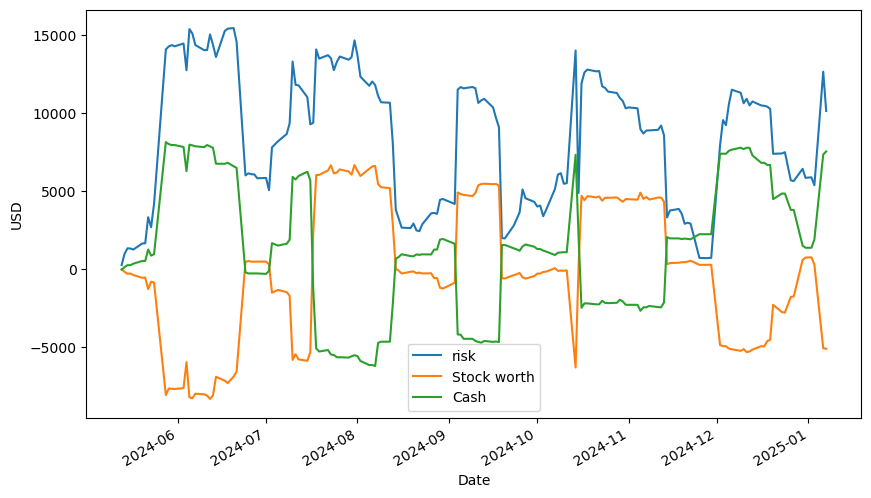

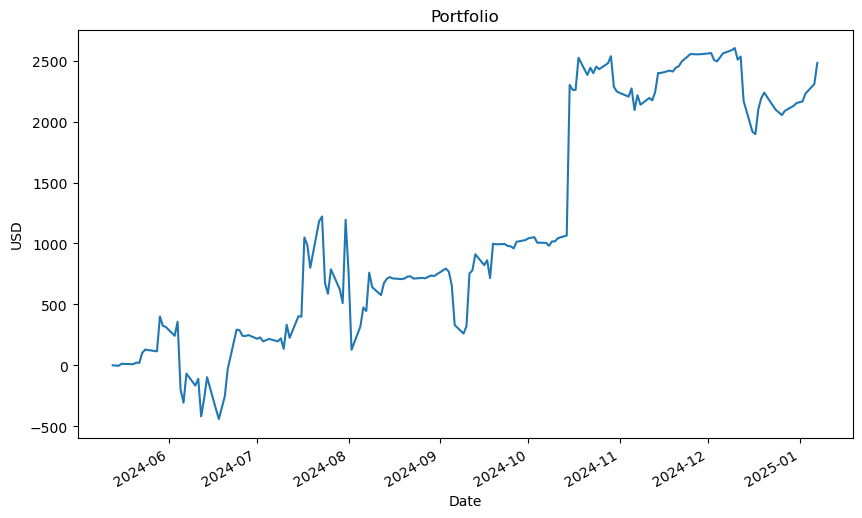

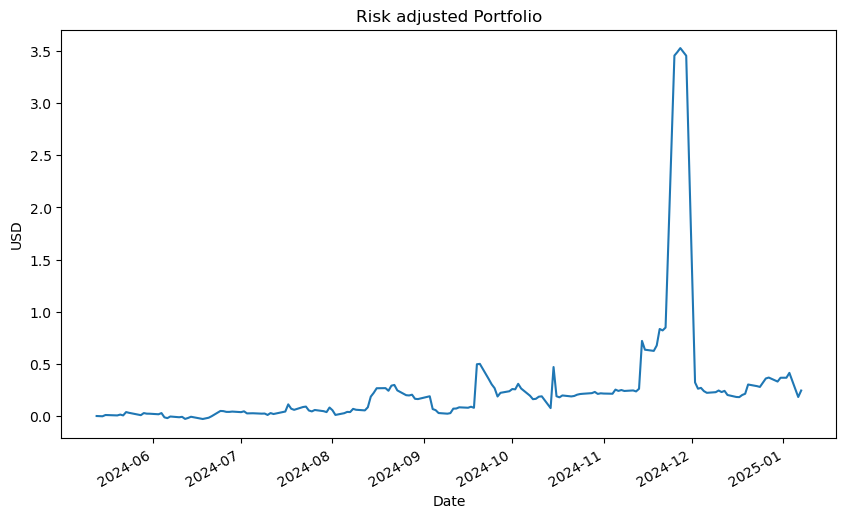

In [449]:
plt.figure(figsize=(10, 6))
Portfolio['risking'].plot(ylabel='USD',label='risk')
Portfolio['stock worth'].plot(label="Stock worth")
Portfolio['cash'].plot(label="Cash")
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
Portfolio['Portfolio'].plot(ylabel='USD',title='Portfolio')
plt.show()

plt.figure(figsize=(10, 6))
(Portfolio['Portfolio']/Portfolio['risking']).plot(ylabel='USD',title='Risk adjusted Portfolio')
plt.show()

In [451]:
print(f"max loss: {Portfolio['Portfolio'].min():.0f} USD")
print(f"max gain: {Portfolio['Portfolio'].max():.0f} USD")
print(f"Max risk: {Portfolio['risking'].max():.0f} USD")

max loss: -440 USD
max gain: 2603 USD
Max risk: 15467 USD


In [453]:
Position_book

Ticker,ADI,AMAT,AMD,ASML,AVGO,LRCX,NVDA,QCOM,TSM,TXN
Date,,,,,,,,,,
2024-05-13,0.0,0.0,1.0,0.0,-1.0,0.0,0.0,0.0,0.0,0.0
2024-05-14,0.0,0.0,1.0,0.0,-2.0,2.0,1.0,0.0,-2.0,0.0
2024-05-15,0.0,-1.0,1.0,0.0,-2.0,2.0,2.0,0.0,-2.0,0.0
2024-05-16,0.0,-1.0,1.0,0.0,-2.0,2.0,2.0,0.0,-2.0,0.0
2024-05-17,0.0,-1.0,-1.0,0.0,-1.0,3.0,2.0,0.0,-2.0,0.0
...,...,...,...,...,...,...,...,...,...,...
2024-12-31,0.0,2.0,6.0,3.0,-9.0,-1.0,0.0,0.0,-2.0,1.0
2025-01-02,0.0,2.0,6.0,3.0,-9.0,-1.0,0.0,0.0,-2.0,1.0
2025-01-03,0.0,2.0,5.0,2.0,-7.0,1.0,-2.0,0.0,-3.0,2.0
